In [ ]:
import pandas as pd
import numpy as np
import vector
import os
from xgboost import XGBClassifier

import HH4b.utils as utils
from HH4b.utils import ShapeVar
import HH4b.plotting as plotting
import HH4b.postprocessing as postprocessing
from HH4b.postprocessing import Region

import hist
import matplotlib.pyplot as plt
import mplhep as hep
import matplotlib.ticker as mticker

formatter = mticker.ScalarFormatter(useMathText=True)
formatter.set_powerlimits((-3, 3))

In [ ]:
# automatically reloads imported files on edits
%load_ext autoreload
%autoreload 2

In [ ]:
samples = {
    "2022": {
        "ttbar": [
            "TTto4Q",
            "TTtoLNu2Q",
            "TTto2L2Nu",
        ],
        "hh4b": [
            "GluGlutoHHto4B_kl-1p00_kt-1p00_c2-0p00_TuneCP5_13p6TeV",
        ],
        "data": [
            "JetMET_Run2022C",
            "JetMET_Run2022C_single",
            "JetMET_Run2022D",
        ],
        "novhhtobb": [
            "GluGluHto2B_PT-200_M-125",
            "VBFHto2B_M-125_dipoleRecoilOn",
        ],
        "vhtobb": [
            "WminusH_Hto2B_Wto2Q_M-125",
            "WplusH_Hto2B_Wto2Q_M-125",
            "ZH_Hto2B_Zto2Q_M-125",
            "ggZH_Hto2B_Zto2Q_M-125",
        ],
        "vbfhh4b": [
            "VBFHHto4B_CV_1_C2V_1_C3_1_TuneCP5_13p6TeV_madgraph-pythia8",
        ],
        "diboson": [
            "WW",
            "ZZ",
        ],
        "vjets": [
            "Wto2Q-3Jets_HT-200to400",
            "Wto2Q-3Jets_HT-400to600",
            "Wto2Q-3Jets_HT-600to800",
            "Wto2Q-3Jets_HT-800",
            "Zto2Q-4Jets_HT-200to400",
            "Zto2Q-4Jets_HT-400to600",
            "Zto2Q-4Jets_HT-600to800",
            "Zto2Q-4Jets_HT-800",
        ],
    },
    "2022EE": {
        "ttbar": [
            "TTto4Q",
            "TTtoLNu2Q",
            "TTto2L2Nu",
        ],
        "hh4b": [
            "GluGlutoHHto4B_kl-1p00_kt-1p00_c2-0p00_TuneCP5_13p6TeV",
        ],
        "data": [
            "JetMET_Run2022E",
            "JetMET_Run2022F",
            "JetMET_Run2022G",
        ],
        "novhhtobb": [
            "GluGluHto2B_PT-200_M-125",
            "VBFHto2B_M-125_dipoleRecoilOn",
        ],
        "qcd": [
            "QCD_HT-200to400",
            "QCD_HT-400to600",
            "QCD_HT-600to800",
            "QCD_HT-800to1000",
            "QCD_HT-1000to1200",
            "QCD_HT-1200to1500",
            "QCD_HT-1500to2000",
            "QCD_HT-2000",
        ],
        "vhtobb": [
            "WminusH_Hto2B_Wto2Q_M-125",
            "WplusH_Hto2B_Wto2Q_M-125",
            "ZH_Hto2B_Zto2Q_M-125",
            "ggZH_Hto2B_Zto2Q_M-125",
        ],
        "vbfhh4b": [
            "VBFHHto4B_CV_1_C2V_1_C3_1_TuneCP5_13p6TeV_madgraph-pythia8",
        ],
        "diboson": [
            "WW",
            "ZZ",
        ],
        "vjets": [
            "Wto2Q-3Jets_HT-200to400",
            "Wto2Q-3Jets_HT-400to600",
            "Wto2Q-3Jets_HT-600to800",
            "Wto2Q-3Jets_HT-800",
            "Zto2Q-4Jets_HT-200to400",
            "Zto2Q-4Jets_HT-400to600",
            "Zto2Q-4Jets_HT-600to800",
            "Zto2Q-4Jets_HT-800",
        ],
    },
    "2023-pre-BPix": {
        "data": [
            "JetMET_Run2023C",
        ],
    },
    "2023-BPix": {
        "data": [
            "JetMET_Run2023D",
        ],
    },
}

MAIN_DIR = "../../../"
dir_name = "24Mar2_v12_signal"
path_to_dir = f"{MAIN_DIR}/../data/skimmer/{dir_name}/"
dirs = {path_to_dir: samples}

load_columns = [
    ("weight", 1),
    ("MET_pt", 1),
    ("nFatJets", 1),
    ("bbFatJetPt", 2),
    ("bbFatJetEta", 2),
    ("bbFatJetPhi", 2),
    ("bbFatJetMsd", 2),
    ("bbFatJetPNetMass", 2),
    ("bbFatJetPNetXbb", 2),
    ("bbFatJetTau3OverTau2", 2),
    ("bbFatJetPNetQCD0HF", 2),
    ("bbFatJetPNetQCD1HF", 2),
    ("bbFatJetPNetQCD2HF", 2),
]

# to-do change this to msd>30
filters = [
    [
        ("('bbFatJetPt', '0')", ">=", 300),
        ("('bbFatJetPt', '1')", ">=", 300),
        ("('bbFatJetMsd', '0')", "<=", 250),
        ("('bbFatJetMsd', '1')", "<=", 250),
        ("('bbFatJetMsd', '0')", ">=", 50),
        ("('bbFatJetMsd', '1')", ">=", 50),
        ("('MET_pt', '0')", "<=", 1000),
    ],
]

events_dict = {}
years = ["2022", "2022EE", "2023-pre-BPix", "2023-BPix"]
for year in years:
    events_dict[year] = {}
    for input_dir, samples in dirs.items():
        events_dict[year] = {
            **events_dict[year],
            **utils.load_samples(
                input_dir,
                samples[year],
                year,
                filters=filters,
                columns_mc=utils.format_columns(load_columns),
            ),
        }

In [ ]:
events_dict.keys()

In [ ]:
variables_not_in_bdt = [
    # not use PnetMass until we debug it
    # "H1PNetMass",
    # not use H2 mass to avoid correlations
    "H2Msd",
    # "H2PNetMass",
    # not use H2Xbb so that we can further cut on it
    "H2Xbb",
    # these sculpt the mass
    "H1_dRH2",
    "H1_dPhiH2",
    # no weight
    "weight",
    # no pt
    "H1Pt",
    "H2Pt",
]


def bdt_dataframe(events):
    h1 = vector.array(
        {
            "pt": events["bbFatJetPt"].to_numpy()[:, 0],
            "phi": events["bbFatJetPhi"].to_numpy()[:, 0],
            "eta": events["bbFatJetEta"].to_numpy()[:, 0],
            "M": events["bbFatJetMsd"].to_numpy()[:, 0],
        }
    )
    h2 = vector.array(
        {
            "pt": events["bbFatJetPt"].to_numpy()[:, 1],
            "phi": events["bbFatJetPhi"].to_numpy()[:, 1],
            "eta": events["bbFatJetEta"].to_numpy()[:, 1],
            "M": events["bbFatJetMsd"].to_numpy()[:, 1],
        }
    )
    hh = h1 + h2

    # bdt variables
    df = pd.DataFrame(
        {
            # dihiggs system
            "HHlogPt": np.log(hh.pt),
            "HHeta": hh.eta,
            "HHmass": hh.mass,
            # met in the event
            "MET": events.MET_pt[0],
            # fatjet tau32
            "H1T32": events["bbFatJetTau3OverTau2"].to_numpy()[:, 0],
            "H2T32": events["bbFatJetTau3OverTau2"].to_numpy()[:, 1],
            # fatjet mass
            "H1Msd": events["bbFatJetMsd"].to_numpy()[:, 0],
            "H2Msd": events["bbFatJetMsd"].to_numpy()[:, 1],
            # fatjet kinematics
            "H1Pt": h1.pt,
            "H2Pt": h2.pt,
            "H1logPt": np.log(h1.pt),
            "H2logPt": np.log(h2.pt),
            "H1eta": h1.eta,
            "H2eta": h2.eta,
            "H1_dRH2": h1.deltaR(h2),
            "H1_dPhiH2": h1.deltaphi(h2),
            # xbb
            "H1Xbb": events["bbFatJetPNetXbb"].to_numpy()[:, 0],
            "H2Xbb": events["bbFatJetPNetXbb"].to_numpy()[:, 1],
            "H1QCD1HF": events["bbFatJetPNetQCD1HF"].to_numpy()[:, 0],
            "H1QCD2HF": events["bbFatJetPNetQCD2HF"].to_numpy()[:, 0],
            "H1QCD0HF": events["bbFatJetPNetQCD0HF"].to_numpy()[:, 0],
            # ratios
            "H1Pt_HHmass": h1.pt / hh.mass,
            "H2Pt_HHmass": h2.pt / hh.mass,
            "H1Pt/H2Pt": h1.pt / h2.pt,
            # weight
            "weight": events["weight"].to_numpy()[:, 0],
        }
    )
    df.replace(np.inf, 10000, inplace=True)
    df.replace(-np.inf, 10000, inplace=True)

    return df

In [ ]:
bdt_model = XGBClassifier()
bdt_model.load_model(fname=f"{MAIN_DIR}/../data/bdt_trainings_run3/boostedBDT_test.json")

events_dict_bdt = {}
for year in years:
    events_dict_bdt[year] = {}
    for key in events_dict[year].keys():
        df_events = bdt_dataframe(events_dict[year][key])
        bdt_score = bdt_model.predict_proba(df_events.drop(columns=variables_not_in_bdt))[:, 1]

        events_dict_bdt[year][key] = df_events
        events_dict_bdt[year][key]["bdt_score"] = bdt_score

In [ ]:
import importlib
import sys
sys.path.append("../boosted/bdt_trainings_run3/")
bdt_model = XGBClassifier()
model_name = "v0"
bdt_model.load_model(
    fname=f"../boosted/bdt_trainings_run3/{model_name}/trained_bdt.model"
)
# get function
make_bdt_dataframe = importlib.import_module(f"{model_name}")

events_dict_bdt = {}
for year in years:
    events_dict_bdt[year] = {}
    for key in events_dict[year].keys():
        df_events = make_bdt_dataframe.bdt_dataframe(events_dict[year][key])
        bdt_score = bdt_model.predict_proba(df_events)[:, 1]
        events_dict_bdt[year][key] = df_events
        events_dict_bdt[year][key]["bdt_score"] = bdt_score
        events_dict_bdt[year][key]["weight"] = events_dict[year][key]["weight"].to_numpy()[:, 0]
        events_dict_bdt[year][key]["H2Msd"] = events_dict[year][key]["bbFatJetMsd"].to_numpy()[:, 1]
        events_dict_bdt[year][key]["H2Xbb"] = events_dict[year][key]["bbFatJetPNetXbb"].to_numpy()[:, 1]


Make a control plot to make sure the normalization is not super off

In [ ]:
control_plot_vars = [
    ShapeVar(var="H2Msd", label=r"$m_{SD}^{2}$ (GeV)", bins=[30, 30, 250]),
    ShapeVar(var="bdt_score", label=r"BDT score", bins=[30, 0, 1]),
]

ylims = {
    "2022": 5e4,
    "2022EE": 4e5,
}

for year in ["2022", "2022EE"]:
    hists = {}
    for shape_var in control_plot_vars:
        if shape_var.var not in hists:
            hists[shape_var.var] = utils.singleVarHist(
                events_dict_bdt[year],
                shape_var,
                weight_key="weight",
            )

    bkgs = ["ttbar", "vhtobb", "vjets", "diboson", "novhhtobb"]
    if year == "2022EE":
        bkgs += ["qcd"]

    plotting.ratioHistPlot(
        hists[shape_var.var],
        year,
        ["hh4b"],
        bkgs,
        name="test",
        show=True,
        log=True,
        plot_significance=False,
        significance_dir=shape_var.significance_dir,
        ratio_ylims=[0.2, 10],
        ylim=ylims[year],
    )

Look into BDT sculpting of H2Msd in data

In [ ]:
cat_axis = hist.axis.StrCategory([], name="Sample", growth=True)
cut_axis = hist.axis.StrCategory([], name="Cut", growth=True)
h2_mass_axis = hist.axis.Regular(40, 0, 300, name="mass", label=r"Higgs 2 mass [GeV]")

hist_h2 = hist.Hist(h2_mass_axis, cut_axis, cat_axis)
bdt_cuts = [0, 0.2, 0.3, 0.5, 0.7, 0.8, 0.9]

for key in ["qcd", "data"]:
    events = events_dict_bdt["2022EE"][key]
    h2_mass = events["H2Msd"]

    for cut in bdt_cuts:
        mask = events["bdt_score"] >= cut
        hist_h2.fill(h2_mass[mask], str(cut), key)

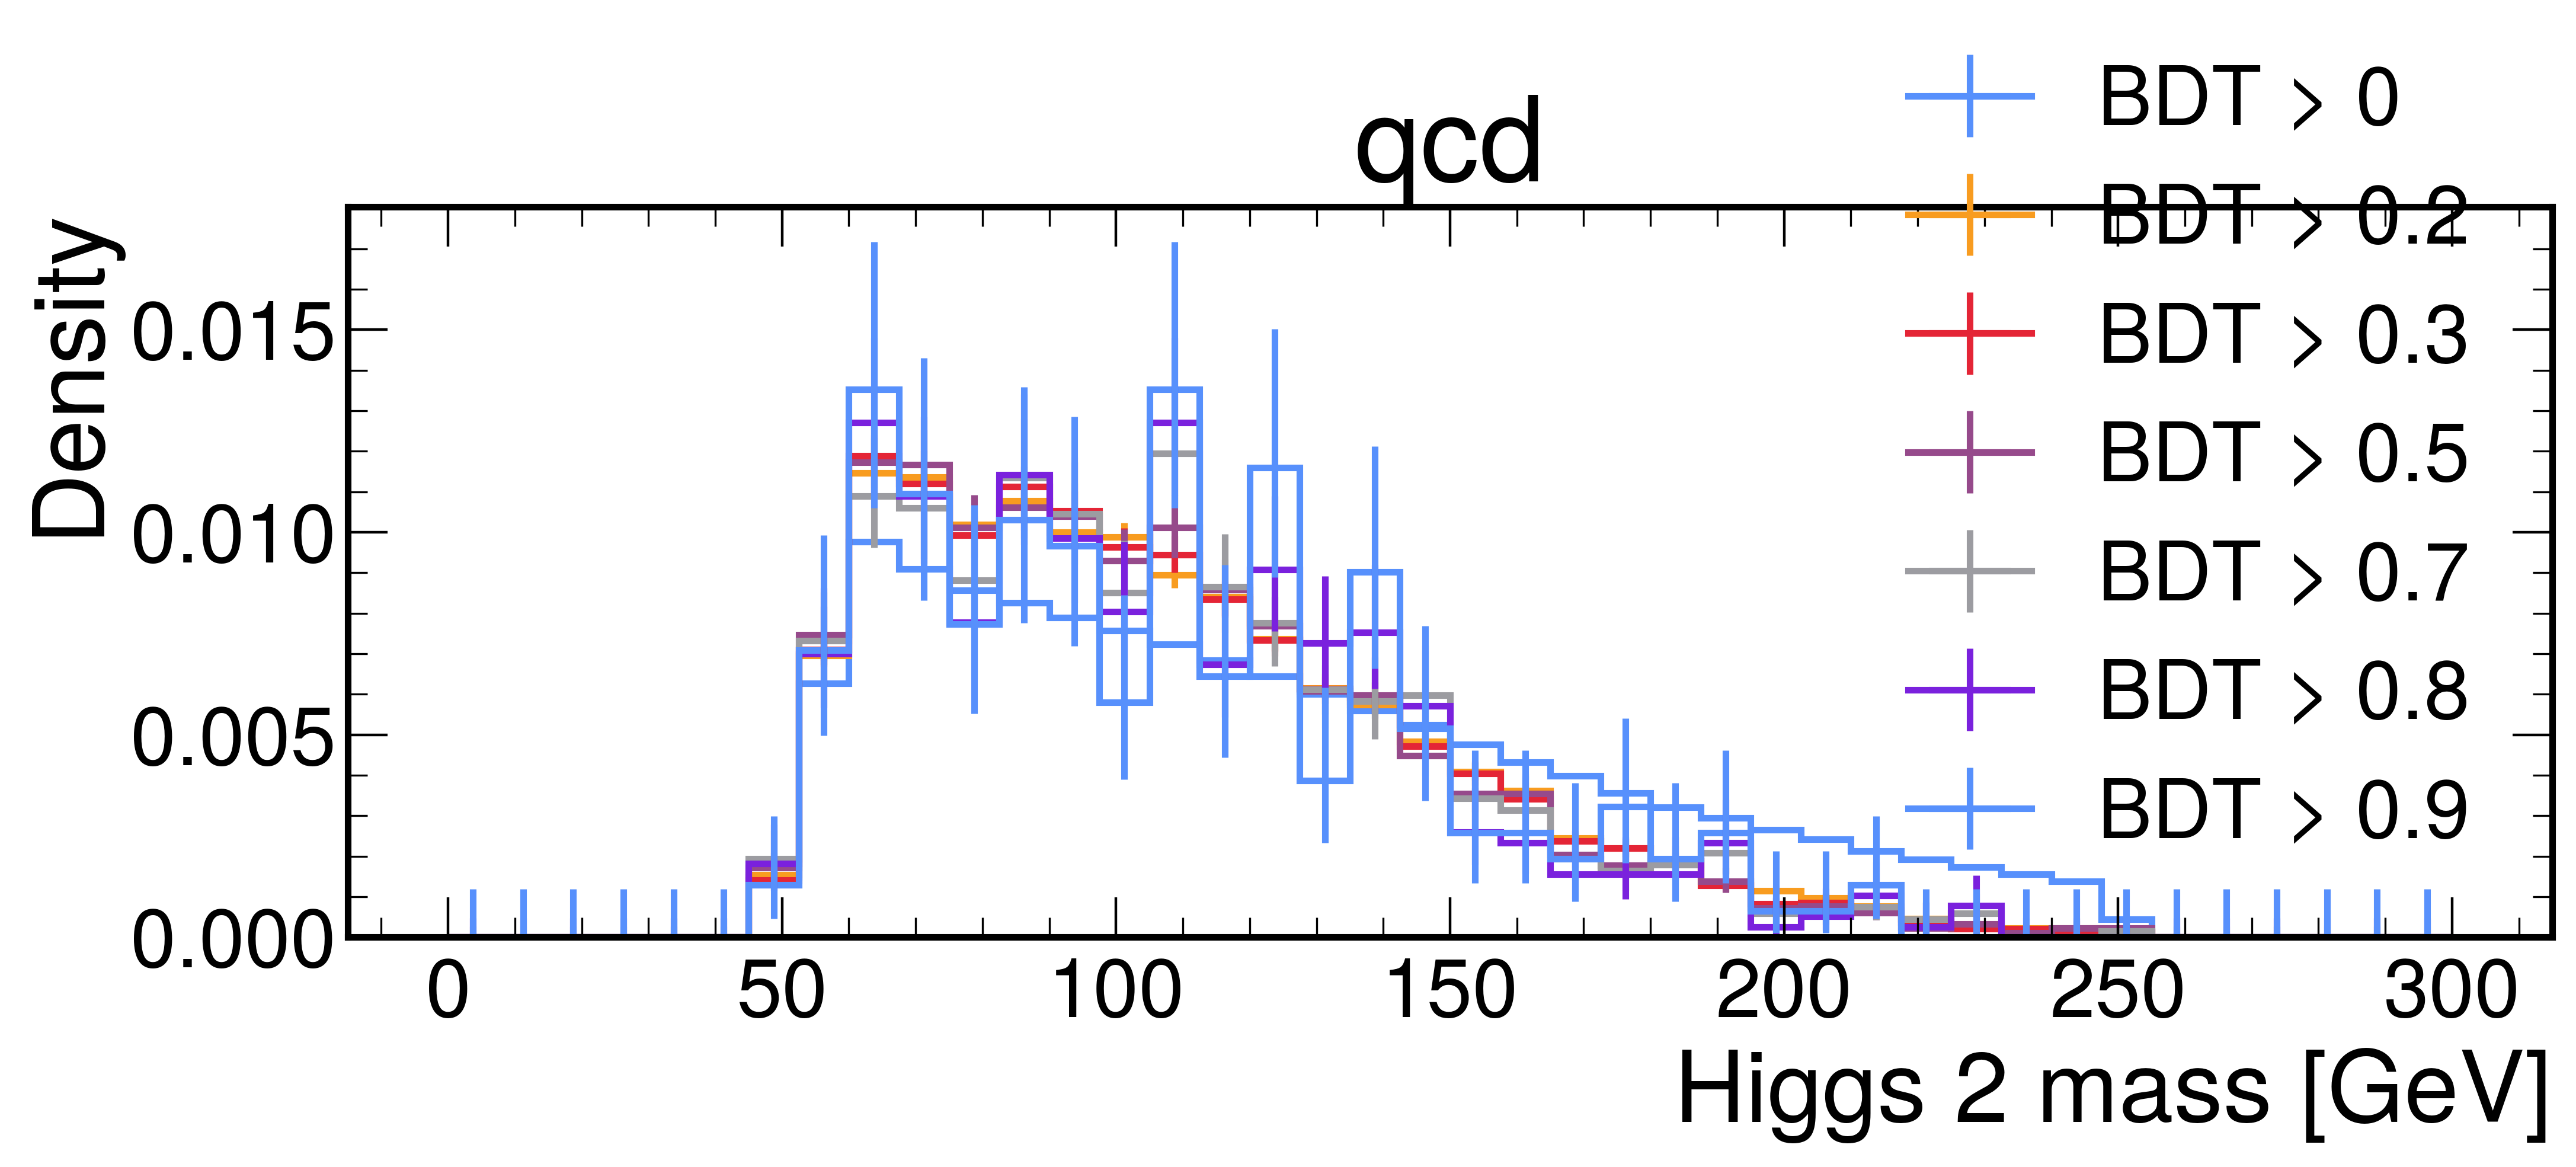

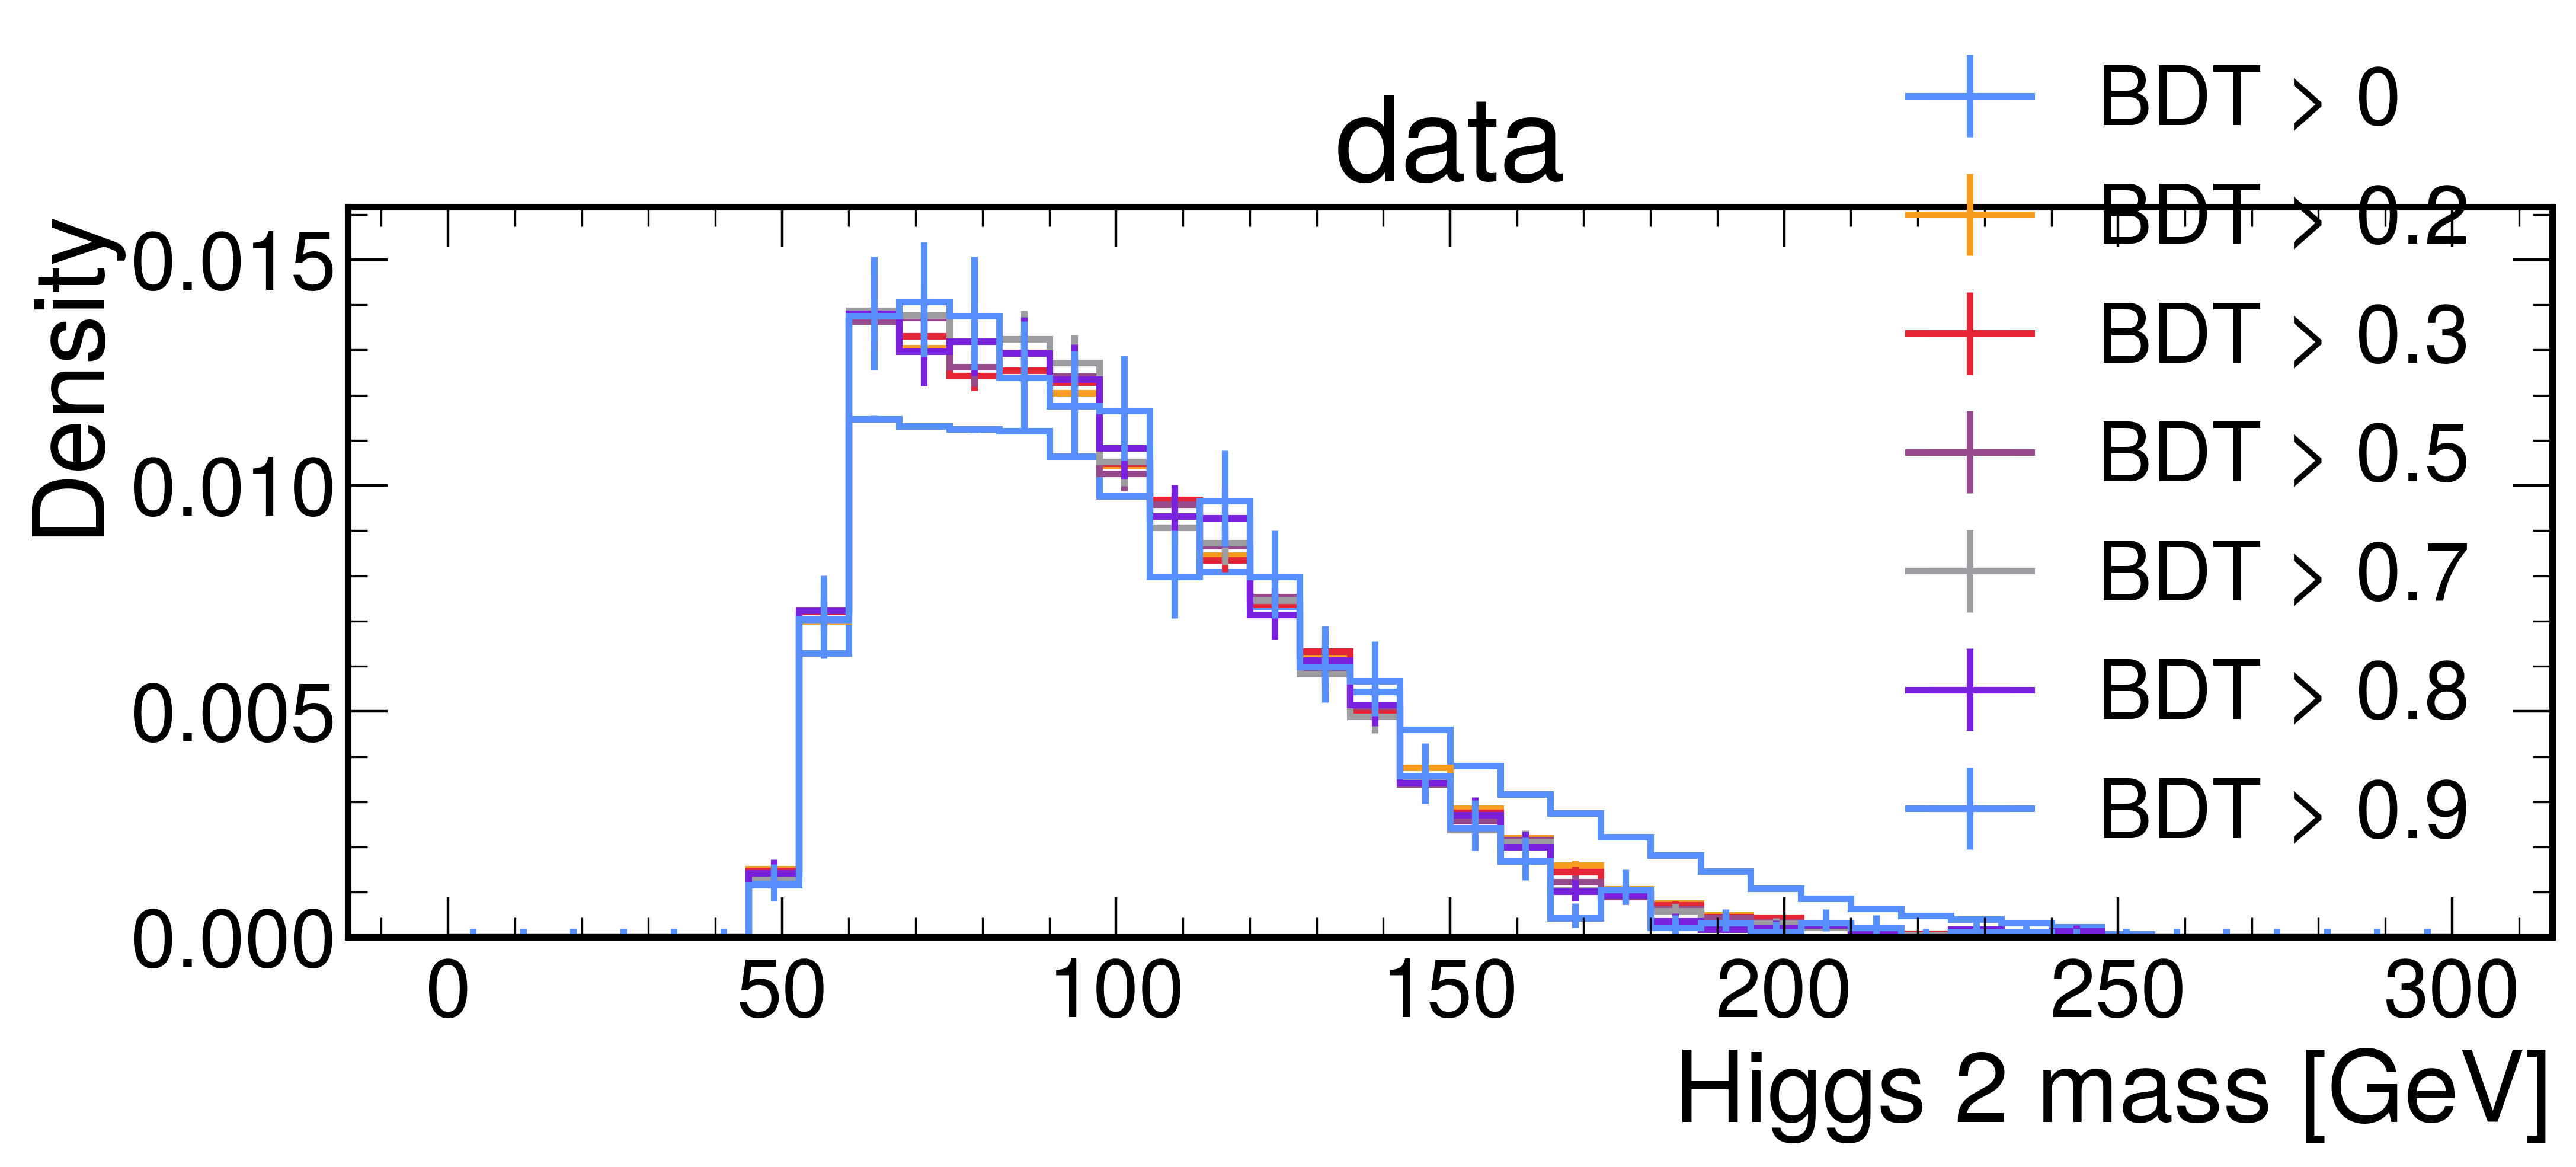

In [10]:
for key in ["qcd", "data"]:
    fig, ax = plt.subplots(1, 1, figsize=(12, 4))
    for cut in bdt_cuts:
        hep.histplot(
            hist_h2[{"Sample": key, "Cut": str(cut)}], lw=2, label=f"BDT > {cut}", density=True
        )
    ax.legend()
    ax.set_ylabel("Density")
    ax.set_title(key)

Create sideband in data
- Estimate number of events that pass BDT & H2Xbb selection

In [ ]:
# create combined datasets
lumi_weight = (7971.4 + 26337.0) / 26337.0

events_dict_bdt_combined = {}
for key in events_dict_bdt["2022EE"].keys():
    if key not in ["qcd", "hh4b", "vbfhh4b"]:
        combined = pd.concat([events_dict_bdt["2022"][key], events_dict_bdt["2022EE"][key]])
    else:
        combined = events_dict_bdt["2022EE"][key].copy()
        combined["weight"] = combined["weight"] * lumi_weight
    events_dict_bdt_combined[key] = combined

In [ ]:
def get_nevents_data(events, xbb_cut, bdt_cut):
    cut_xbb = events["H2Xbb"] > xbb_cut
    cut_bdt = events["bdt_score"] > bdt_cut
    cut_msd = (events["H2Msd"] > 50) & (events["H2Msd"] < 220)

    # get yield between 75-95
    cut_msd_0 = (events["H2Msd"] < 95) & (events["H2Msd"] > 75)

    # get yield between 135-155
    cut_msd_1 = (events["H2Msd"] < 155) & (events["H2Msd"] > 135)

    return np.sum(cut_msd_0 & cut_xbb & cut_bdt & cut_msd) + np.sum(
        cut_msd_1 & cut_xbb & cut_bdt & cut_msd
    )


def get_nevents_signal(events, xbb_cut, bdt_cut):
    cut_xbb = events["H2Xbb"] > xbb_cut
    cut_bdt = events["bdt_score"] > bdt_cut
    cut_msd = (events["H2Msd"] > 95) & (events["H2Msd"] < 135)

    # get yield
    # for signal, we use the lumi weight to scale the same signal by the total lumi (2022, 2022EE)
    return np.sum(events["weight"][cut_xbb & cut_bdt & cut_msd])


for xbb_cut in [0.8, 0.9, 0.95, 0.98]:
    figure_of_merits = []
    cuts = []
    for bdt_cut in np.arange(0.01, 1, 0.01):
        nevents_data = get_nevents_data(events_dict_bdt_combined["data"], xbb_cut, bdt_cut)
        nevents_signal = get_nevents_signal(events_dict_bdt_combined["hh4b"], xbb_cut, bdt_cut)

        figure_of_merit = 2 * np.sqrt(nevents_data) / nevents_signal

        if nevents_signal > 0.5:
            cuts.append(bdt_cut)
            figure_of_merits.append(figure_of_merit)
            print(
                f"Xbb_Cut: {xbb_cut}, BDT_Cut: {bdt_cut:.2f}, NBkg: {nevents_data}, NSig: {nevents_signal:.2f}, FOM: {figure_of_merit:.2f}"
            )

    if len(cuts) > 0:
        cuts = np.array(cuts)
        figure_of_merits = np.array(figure_of_merits)
        smallest = np.argmin(figure_of_merits)

        print(xbb_cut, cuts[smallest], figure_of_merits[smallest])

In [ ]:
# got yields similar to cut based
# txbb_cut = 0.95
# bdt_cut = 0.05

txbb_cut = 0.9
bdt_cut = 0.62

# txbb_cut = 0.8
# bdt_cut = 0.72

# txbb_cut = 0.95
# bdt_cut = 0.62

selection_regions = {
    "pass": Region(
        cuts={
            "H2Xbb": [txbb_cut, 1],
            "bdt_score": [bdt_cut, 1],
        },
        label="Pass",
    ),
    "fail": Region(
        cuts={
            "H2Xbb": [0, txbb_cut],
            "bdt_score": [0.03, 1],
        },
        label="Fail",
    ),
}

fit_shape_var = ShapeVar(
    "H2Msd",
    r"$m^{2}_\mathrm{SD}$ (GeV)",
    [17, 50, 220],
    reg=True,
    blind_window=[110, 140],
)

templ_dir = "./templates/15Mar24/"
year = "2022All"
os.system(f"mkdir -p {templ_dir}/{year}")
os.system(f"mkdir -p {templ_dir}/cutflows/{year}")

templates = postprocessing.get_templates(
    events_dict_bdt_combined,
    bb_masks=None,
    year="2022All",
    sig_keys=["hh4b"],
    selection_regions=selection_regions,
    shape_vars=[fit_shape_var],
    systematics={},
    template_dir=f"{templ_dir}",
    bg_keys=["qcd", "ttbar", "vhtobb", "vjets", "diboson", "novhhtobb"],
    plot_dir=f"{templ_dir}/{year}",
    weight_key="weight",
    show=True,
    energy=13.6,
)

In [ ]:
txbb_cut = 0.95

selection_regions = {
    "pass": Region(
        cuts={
            "H1Xbb": [txbb_cut, 1],
            "H2Xbb": [txbb_cut, 1],
            "H1Msd": [100, 150],
        },
        label="Pass",
    ),
    "fail": Region(
        cuts={
            "H1Xbb": [0, txbb_cut],
            "H2Xbb": [0, txbb_cut],
            "H1Msd": [100, 150],
        },
        label="Fail",
    ),
}

fit_shape_var = ShapeVar(
    "H2Msd",
    r"$m^{2}_\mathrm{SD}$ (GeV)",
    [16, 60, 220],
    reg=True,
    blind_window=[110, 140],
)

templ_dir = "./templates/15Mar24-cutbased/"
year = "2022All"
os.system(f"mkdir -p {templ_dir}/{year}")
os.system(f"mkdir -p {templ_dir}/cutflows/{year}")

templates = postprocessing.get_templates(
    events_dict_bdt_combined,
    bb_masks=None,
    year="2022All",
    sig_keys=["hh4b"],
    selection_regions=selection_regions,
    shape_vars=[fit_shape_var],
    systematics={},
    template_dir=f"{templ_dir}",
    bg_keys=["qcd", "ttbar", "vhtobb", "vjets", "diboson", "novhhtobb"],
    plot_dir=f"{templ_dir}/{year}",
    weight_key="weight",
    show=True,
    energy=13.6,
)

Adding Run-3 data

In [ ]:
events_dict_bdt["2022EE"].keys()

In [ ]:
# create combined datasets
lumi_weight_2022EEtoall = (7971.4 + 26337.0 + 17650.0 + 9451.0) / 26337.0

events_dict_bdt_combined_2023 = {}
for key in ["data", "hh4b", "qcd", "ttbar", "vhtobb", "vjets", "diboson", "novhhtobb"]:
    if key == "data":
        combined = pd.concat(
            [
                events_dict_bdt["2022"][key],
                events_dict_bdt["2022EE"][key],
                events_dict_bdt["2023-pre-BPix"][key],
                events_dict_bdt["2023-BPix"][key],
            ]
        )
    else:
        combined = events_dict_bdt["2022EE"][key].copy()
        combined["weight"] = combined["weight"] * lumi_weight_2022EEtoall
    events_dict_bdt_combined_2023[key] = combined

In [ ]:
for xbb_cut in [0.8, 0.9, 0.95, 0.98]:
    figure_of_merits = []
    cuts = []
    for bdt_cut in np.arange(0.01, 1, 0.01):
        nevents_data = get_nevents_data(events_dict_bdt_combined_2023["data"], xbb_cut, bdt_cut)
        nevents_signal = get_nevents_signal(events_dict_bdt_combined_2023["hh4b"], xbb_cut, bdt_cut)

        figure_of_merit = 2 * np.sqrt(nevents_data) / nevents_signal

        if nevents_signal > 0.5:
            cuts.append(bdt_cut)
            figure_of_merits.append(figure_of_merit)
            print(
                f"Xbb_Cut: {xbb_cut}, BDT_Cut: {bdt_cut:.2f}, NBkg: {nevents_data}, NSig: {nevents_signal:.2f}, FOM: {figure_of_merit:.2f}"
            )

    if len(cuts) > 0:
        cuts = np.array(cuts)
        figure_of_merits = np.array(figure_of_merits)
        smallest = np.argmin(figure_of_merits)

        print(xbb_cut, cuts[smallest], figure_of_merits[smallest])

In [ ]:
txbb_cut = 0.9
bdt_cut = 0.93

selection_regions = {
    "pass": Region(
        cuts={
            "H2Xbb": [txbb_cut, 1],
            "bdt_score": [bdt_cut, 1],
        },
        label="Pass",
    ),
    "fail": Region(
        cuts={
            "H2Xbb": [0, txbb_cut],
            "bdt_score": [0.03, 1],
        },
        label="Fail",
    ),
}

fit_shape_var = ShapeVar(
    "H2Msd",
    r"$m^{2}_\mathrm{SD}$ (GeV)",
    [17, 50, 220],
    reg=True,
    blind_window=[110, 140],
)

templ_dir = "./templates/15Mar24/"
year = "2022-2023"
os.system(f"mkdir -p {templ_dir}/{year}")
os.system(f"mkdir -p {templ_dir}/cutflows/{year}")

templates = postprocessing.get_templates(
    events_dict_bdt_combined_2023,
    bb_masks=None,
    year="2022-2023",
    sig_keys=["hh4b"],
    selection_regions=selection_regions,
    shape_vars=[fit_shape_var],
    systematics={},
    template_dir=f"{templ_dir}",
    bg_keys=["qcd", "ttbar", "vhtobb", "vjets", "diboson", "novhhtobb"],
    plot_dir=f"{templ_dir}/{year}",
    weight_key="weight",
    show=True,
    energy=13.6,
)

In [ ]:
txbb_cut = 0.985

selection_regions = {
    "pass": Region(
        cuts={
            "H1Xbb": [txbb_cut, 1],
            "H2Xbb": [txbb_cut, 1],
            #"H1Msd": [100, 150],
        },
        label="Pass",
    ),
    "fail": Region(
        cuts={
            "H1Xbb": [0, txbb_cut],
            "H2Xbb": [0, txbb_cut],
            #"H1Msd": [100, 150],
        },
        label="Fail",
    ),
}

fit_shape_var = ShapeVar(
    "H2Msd",
    r"$m^{2}_\mathrm{SD}$ (GeV)",
    [17, 50, 220],
    reg=True,
	blind_window=[110, 140],
)

templ_dir = "./templates/15Mar24-cutbased/"
year = "2022-2023"
os.system(f"mkdir -p {templ_dir}/{year}")
os.system(f"mkdir -p {templ_dir}/cutflows/{year}")

templates = postprocessing.get_templates(
    events_dict_bdt_combined_2023,
    bb_masks=None,
    year="2022-2023",
    sig_keys=["hh4b"],
    selection_regions=selection_regions,
    shape_vars=[fit_shape_var],
    systematics={},
    template_dir=f"{templ_dir}",
    bg_keys=["qcd", "ttbar", "vhtobb", "vjets", "diboson", "novhhtobb"],
    plot_dir=f"{templ_dir}/{year}",
    weight_key="weight",
    show=True,
    energy=13.6,
)